In [1]:
import tensorflow as tf

def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

select_gpu(2)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [2]:
import re

In [3]:
sequence_length = 128
epochs = 10
model_name = 'bert-chinese'

In [4]:
def txt_to_list(path, sequence_length):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
#         text_list = [i for i in text]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
#                 print(entity)            
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
        
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
#             while len(sentence) < sequence_length:
#                 sentence += 'O'
#             if len(sentence) > sequence_length:
#                 sentence = sentence[:sequence_length]
            x.append([i for i in sentence])
            
        tmp = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
#                 while len(tmp) < sequence_length:
#                     tmp.append('O')
#                 if len(tmp) > sequence_length:
#                     tmp = tmp[:sequence_length]
                y.append(tmp)
                tmp = list()
            else:
                tmp.append(i)
        y.append(label_list)
    return [x, y]

In [5]:
x1, y1 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt', sequence_length)

In [6]:
x2, y2 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt', sequence_length)

In [7]:
x4, y4 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt', sequence_length)

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76508
76508


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48964 48964
12242 12242
15302 15302


In [10]:
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
embed_path = '/home/Danny/pretrain_model/{}'.format(model_name)
bert_embed = BertEmbedding(embed_path, sequence_length=sequence_length)
model = BiLSTM_CRF_Model(bert_embed)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=256,
                   )

2020-12-03 00:30:34,558 [DEBUG] kashgari - ------------------------------------------------
2020-12-03 00:30:34,558 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-03 00:30:34,559 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-03 00:30:34,559 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-03 00:30:34,559 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-03 00:30:34,560 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/10
191/191 [==============================] - 43s 224ms/step - loss: 0.7751 - accuracy: 0.9655 - val_loss: 24.2524 - val_accuracy: 0.9852
Epoch 2/10
191/191 [==============================] - 40s 208ms/step - loss: 0.2196 - accuracy: 0.9855 - val_loss: 24.0561 - val_accuracy: 0.9883
Epoch 3/10
191/191 [==============================] - 40s 209ms/step - loss: 0.1680 - accuracy: 0.9883 - val_loss: 23.8687 - val_accuracy: 0.9890
Epoch 4/10
191/191 [==============================] - 40s 209ms/step - loss: 0.1387 - accuracy: 0.9892 - val_loss: 23.7366 - val_accuracy: 0.9905
Epoch 5/10
191/191 [==============================] - 40s 209ms/step - loss: 0.1165 - accuracy: 0.9907 - val_loss: 23.5426 - val_accuracy: 0.9906
Epoch 6/10
191/191 [==============================] - 40s 210ms/step - loss: 0.1032 - accuracy: 0.9912 - val_loss: 23.3804 - val_accuracy: 0.9899
Epoch 7/10
191/191 [==============================] - 40s 210ms/step - loss: 0.0889 - accuracy: 0.9920 - val_loss: 23.1976 -

In [11]:
model.evaluate(test_x, test_y)
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)

2020-12-03 00:37:39,033 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 72
2020-12-03 00:37:39,127 [DEBUG] kashgari - predict seq_length: None, input: (2, 15302, 72)


479/479 [==============================] - 44s 91ms/step


2020-12-03 00:38:26,749 [DEBUG] kashgari - predict output: (15302, 72)
2020-12-03 00:38:26,750 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

         money     0.6029    0.7885    0.6833        52
          time     0.7764    0.7983    0.7872       848
          name     0.9000    0.8100    0.8526       100
        family     0.8182    0.5294    0.6429        17
      location     0.9310    0.8901    0.9101        91
      med_exam     0.8309    0.8071    0.8188       140
       contact     0.4545    0.3846    0.4167        13
            ID     0.6000    0.3750    0.4615         8
    profession     0.5000    0.2222    0.3077         9
clinical_event     0.0000    0.0000    0.0000         4
     education     0.0000    0.0000    0.0000         1
  organization     0.0000    0.0000    0.0000         3

     micro avg     0.7875    0.7869    0.7872      1286
     macro avg     0.7853    0.7869    0.7843      1286



2020-12-03 00:38:35,728 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-10


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-10'

In [12]:
from matplotlib import pyplot as plt

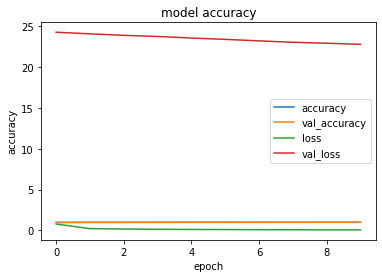

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [14]:
import pandas as pd
df = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/stage4/development_2.csv')
df

,Unnamed: 0,article_id,text
0,0,0,醫師：這個要電腦看才有辦法，這是嚴重或一般的。民眾：這是沒關係啦。醫師：沒關係齁。民眾：他一...
1,1,1,醫師：就照舊這樣子。阿這一定要跟你講一下。家屬：沒關係啊。醫師：阿最近好嗎？民眾：都正常。醫...
2,2,2,醫師：就照這樣，我們就照這樣問診這樣而已啦，阿最近我們8月17號有抽血。家屬：對上上個禮拜。...
3,3,3,醫師：最近有怎麼樣嗎？民眾：都一樣欸。醫師：會痛還是怎麼樣嗎？民眾：都一樣。醫師：有發燒或是...
4,4,4,民眾：前一次是6月14號。醫師：嗯，14。民眾：13還是14。醫師：我看一下14啊，13和1...
...,...,...,...
65,65,65,個管師：來坐這裡。民眾：好，坐這裡嗎？好，靠你那麼近？個管師：靠我近一點好啊，不好嗎？會讓你...
66,66,66,個管師：好喘……哈哈哈哈。民眾：哈哈。個管師：好。小明這個月還好嗎？民眾：很好啊。個管師：很...
67,67,67,個管師：所以你是去篩檢的時候……民眾：恩。個管師：你去篩檢的時候然後許小姐跟你說你可以來這邊...
68,68,68,個管師：好喔，過去這一個月還好嗎？民眾：恩，還可以。個管師：那今天是請假？民眾：沒有，晚上上...


In [15]:
def predict_NER(model, text, sequence_length):
    x_list = list()
    while len(text) > sequence_length:
        x_list.append([i for i in text[:sequence_length]])
        text = text[sequence_length:]        
    x_list.append([i for i in text[:sequence_length]])
    y_list = model.predict(x_list)
    for i, j in zip(x_list, y_list):
    merge_list = list()
    for i in y_list:
        for j in i:
            merge_list.append(j)
    return merge_list

IndentationError: expected an indented block (<ipython-input-15-fd2b14f31c9e>, line 9)

In [ ]:
def output_NER(article_id, text, y):
    output = str()
    flag = False
    for i, j in enumerate(y):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            output += '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
    return output

In [ ]:
output="article_id\tstart_position\tend_position\tentity_text\tentity_type\n"
for article_id, text in zip(df['article_id'], df['text']):
    y = predict_NER(model, text, sequence_length)
    output += output_NER(article_id, text, y)

In [ ]:
print(output)

In [ ]:
output_path='output/{}_epo_{}.tsv'.format(model_name, epochs)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output)